Plant Phenotyping of Sorghum to predict Biomass and Improve the original model in use

Name : Ayushh

Roll No. 210070017

Guide: Prof. Adinarayana

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.constraints import MinMaxNorm, MaxNorm
from keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping

from scipy.stats.stats import pearsonr

<ipython-input-1-2fcb0107e970>:18: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 3dec21dec - Sheet1.csv to 3dec21dec - Sheet1.csv
Saving 8dec - Sheet1.csv to 8dec - Sheet1.csv
Saving 8dec17dec - Sheet1.csv to 8dec17dec - Sheet1.csv
Saving 17dec - Sheet1.csv to 17dec - Sheet1.csv


In [ ]:
# df8 = pd.read_csv("8dec.csv")
# df17 = pd.read_csv("17dec.csv")
# df817 = pd.read_csv("8dec17dec.csv")
# df321 = pd.read_csv("3dec21dec.csv")

df8 = pd.read_csv("8dec - Sheet1.csv")
df17 = pd.read_csv("17dec - Sheet1.csv")
df817 = pd.read_csv("8dec17dec - Sheet1.csv")
df321 = pd.read_csv("3dec21dec - Sheet1.csv")

from pathlib import Path
image_dir= Path("/content/gdrive/MyDrive/AYUSHH/Xtest8dec17dec")
# image_dir= Path("Xtest8dec17dec")
filepaths_1 = pd.Series(list(image_dir.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_1 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_1]
sorted_filepaths_1 = [x for _, x in sorted(zip(numeric_parts_1, filepaths_1))]
filepaths_series_1 = pd.Series(sorted_filepaths_1, name='Filepath')
bmass_1 = df817['Biomass']
test_img =  pd.concat([filepaths_series_1,bmass_1],axis=1)

image_dir_3= Path("/content/gdrive/MyDrive/AYUSHH/Xtrain3dec21dec")
# image_dir_3= Path("Xtrain3dec21dec")
filepaths_3 = pd.Series(list(image_dir_3.glob(r'**/*.png')), name = 'Filepath').astype(str)
numeric_parts_3 = [int(filepath.split('/')[-1].split('.')[0][len('image'):]) for filepath in filepaths_3]
sorted_filepaths_3 = [x for _, x in sorted(zip(numeric_parts_3, filepaths_3))]
filepaths_series_3 = pd.Series(sorted_filepaths_3, name='Filepath')
bmass_3 = df321['Biomass']
train_img = pd.concat([filepaths_series_3,bmass_3],axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_img['Biomass'] = scaler.fit_transform(train_img['Biomass'].values.reshape(-1, 1))  # leanrt u and sigma for train data

In [ ]:
train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator( # data_gen object -- in parameters ke according iamge par operation
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_data = train_generator_aug.flow_from_dataframe(      #6D --- (5D,2D) tensor ( #batches and other 4)
    dataframe=train_img,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512), # why use this?
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,   # small batch size -- noisier gradient descent
    shuffle=True,
    seed=42,
    subset='training'
)
# X_train, y_train = next(train_data)   # batch data
# X_train2,y_train2= train_images       # too much data to unpack

val_data = train_generator_aug.flow_from_dataframe(
    dataframe=train_img,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,
    shuffle=True,
    seed=42,
    subset='validation'
)
# X_val, y_val = next(val_images)

test_data = test_generator_aug.flow_from_dataframe(
    dataframe=test_img,
    x_col='Filepath',
    y_col='Biomass',
    target_size=(512,512),
    color_mode='rgb',
    class_mode='raw',
    batch_size=2,
    shuffle=False
)
# X_test, y_test = next(test_images)
# X_test shape is 2,512,512,3
# y_test shape is (2,)

Found 87 validated image filenames.
Found 21 validated image filenames.
Found 108 validated image filenames.


In [ ]:
import tensorflow as tf
from keras.applications import MobileNetV2

# Load MobileNetV2 model without top (fully connected layers)
base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom regression head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

# Print model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 256, 256, 32  128         ['Conv1[0][0]']                  
                               

Epoch 1/150
22/22 [==============================] - 26s 591ms/step - loss: 1.4040 - mae: 0.9323 - root_mean_squared_error: 1.1849 - val_loss: 0.1027 - val_mae: 0.2683 - val_root_mean_squared_error: 0.3204
Epoch 2/150
22/22 [==============================] - 9s 405ms/step - loss: 1.0701 - mae: 0.7617 - root_mean_squared_error: 1.0345 - val_loss: 0.1115 - val_mae: 0.2858 - val_root_mean_squared_error: 0.3340
Epoch 3/150
22/22 [==============================] - 10s 460ms/step - loss: 0.7283 - mae: 0.7072 - root_mean_squared_error: 0.8534 - val_loss: 0.0688 - val_mae: 0.1945 - val_root_mean_squared_error: 0.2623
Epoch 4/150
22/22 [==============================] - 10s 453ms/step - loss: 0.6642 - mae: 0.6682 - root_mean_squared_error: 0.8150 - val_loss: 0.1252 - val_mae: 0.3097 - val_root_mean_squared_error: 0.3539
Epoch 5/150
22/22 [==============================] - 8s 382ms/step - loss: 0.5850 - mae: 0.6297 - root_mean_squared_error: 0.7649 - val_loss: 0.2139 - val_mae: 0.4147 - val_root

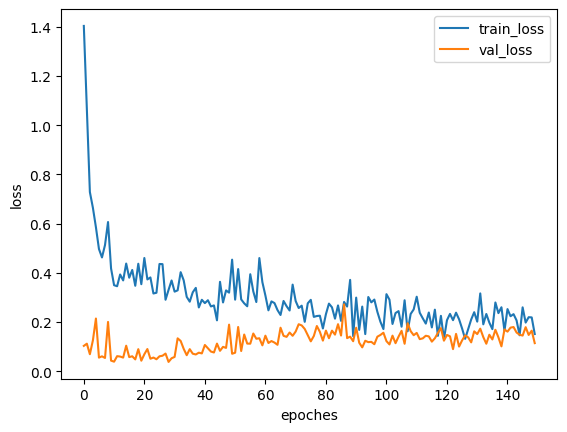

In [ ]:
import time
t0=time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=150,
    verbose=1,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)
print("Training time:", time.time()-t0)  # look at the last line

history.history.keys()

# plot history
# summarize history for loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()
plt.show()

**KINDLY MAKE REQUIRED CHANGES IN PATH**

In [ ]:
model_path = '/content/gdrive/MyDrive/AYUSHH/newmobinet.h5'
# Save the entire model (architecture and weights)
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


In [ ]:
#predicting scores of the val set loss(mse) metric(mae) metric(rmse) 3dec21dec 20 % r s=42
scoresval = model.evaluate(val_data, verbose=0)
print("val mse(loss)    val_mae     val_rmse")
print(scoresval)

val mse(loss)    val_mae     val_rmse
[0.10835515707731247, 0.2983276844024658, 0.3291734457015991]


In [ ]:
Pred= model.predict(test_data)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = test_img['Biomass'].values.reshape(-1, 1)

54/54 [==============================] - 70s 1s/step


In [ ]:
lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

LinearRegression()

Test dataset prediction - 8dec
euqation of line is : y=[0.42962333]*x + [228.83677733]
r2 score= 0.745
mae=151.394
mse=32,149.315
rmse=179.302


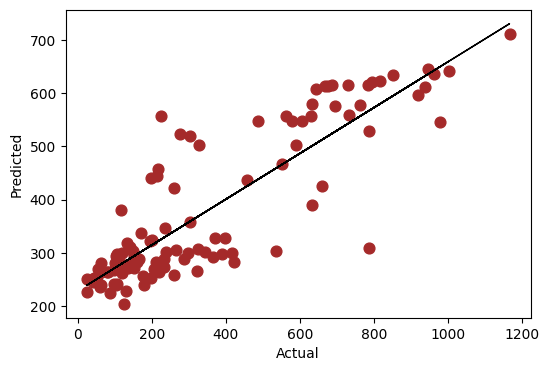

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - 8dec")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))

In [ ]:
import tensorflow as tf
from keras.applications import MobileNetV2

# Load MobileNetV2 model without top (fully connected layers)
base_model = MobileNetV2(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Add custom regression head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_layer = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'RootMeanSquaredError'])

9406464/9406464 [==============================] - 1s 0us/step


Epoch 1/125
22/22 [==============================] - 90s 3s/step - loss: 2.2289 - mae: 1.2478 - root_mean_squared_error: 1.4929 - val_loss: 0.3682 - val_mae: 0.5457 - val_root_mean_squared_error: 0.6068
Epoch 2/125
22/22 [==============================] - 9s 417ms/step - loss: 1.6501 - mae: 1.0694 - root_mean_squared_error: 1.2846 - val_loss: 0.2741 - val_mae: 0.4676 - val_root_mean_squared_error: 0.5235
Epoch 3/125
22/22 [==============================] - 10s 470ms/step - loss: 1.1404 - mae: 0.8549 - root_mean_squared_error: 1.0679 - val_loss: 0.4545 - val_mae: 0.6395 - val_root_mean_squared_error: 0.6742
Epoch 4/125
22/22 [==============================] - 10s 464ms/step - loss: 0.9308 - mae: 0.7835 - root_mean_squared_error: 0.9648 - val_loss: 0.1179 - val_mae: 0.2938 - val_root_mean_squared_error: 0.3434
Epoch 5/125
22/22 [==============================] - 9s 398ms/step - loss: 0.7430 - mae: 0.6845 - root_mean_squared_error: 0.8619 - val_loss: 0.2310 - val_mae: 0.4495 - val_root_me

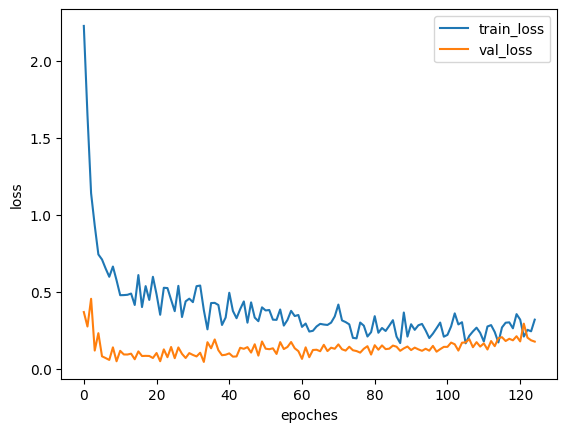

In [ ]:
import time
t0=time.time()
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=125,
    verbose=1,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)
print("Training time:", time.time()-t0)  # look at the last line

history.history.keys()

# plot history
# summarize history for loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel("epoches")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
dkdkdx

In [ ]:
model_path = '/content/gdrive/MyDrive/AYUSHH/mobinet3.h5'
# Save the entire model (architecture and weights)
model.save(model_path)
print("Model saved successfully.")

Model saved successfully.


In [ ]:
#predicting scores of the val set loss(mse) metric(mae) metric(rmse) 3dec21dec 20 % r s=42
scoresval = model.evaluate(val_data, verbose=0)
print("val mse(loss)    val_mae     val_rmse")
print(scoresval)

val mse(loss)    val_mae     val_rmse
[0.1831214427947998, 0.37539029121398926, 0.4279268980026245]


In [ ]:
Pred= model.predict(test_data)
pred_testunscaled = scaler.inverse_transform(Pred)
y_test_all = test_img['Biomass'].values.reshape(-1, 1)

54/54 [==============================] - 101s 2s/step


In [ ]:
lm = LinearRegression()
lm.fit(y_test_all,pred_testunscaled)

LinearRegression()

Test dataset prediction - 8dec
euqation of line is : y=[0.33578732]*x + [257.67072098]
r2 score= 0.686
mae=171.225
mse=40,336.755
rmse=200.840


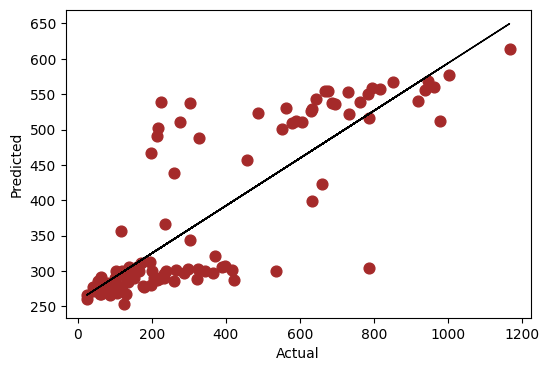

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_test_all,pred_testunscaled,color='brown',s=60)
ax.plot(y_test_all,lm.predict(y_test_all), color='black', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
print("Test dataset prediction - 8dec")

print("euqation of line is : y="+str(lm.coef_[0])+"*x + "+str(lm.intercept_))

print("r2 score= {:,.3f}".format(lm.score(y_test_all,pred_testunscaled)))
print("mae={:,.3f}".format(metrics.mean_absolute_error(y_test_all,pred_testunscaled)))
print("mse={:,.3f}".format(metrics.mean_squared_error(y_test_all,pred_testunscaled)))
print("rmse={:,.3f}".format(np.sqrt(metrics.mean_squared_error(y_test_all,pred_testunscaled))))